# 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKT-AI/KoBART to /tmp/pip-install-thitjuar/kobart_33a456b99b3c472bb80f1436930c328b
  Running command git clone -q https://github.com/SKT-AI/KoBART /tmp/pip-install-thitjuar/kobart_33a456b99b3c472bb80f1436930c328b


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import os 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW

from tqdm import tqdm

In [5]:
data = pd.read_csv("/content/drive/MyDrive/KUBIG 썸네일 프로젝트/전처리코드/전처리_data(이모지 그대로).csv",index_col=0)
#data.drop(['channel_name','title','date','thumbnail','videoId','URL'],axis=1,inplace=True)

In [6]:
data.shape

(54454, 16)

In [7]:
data.columns

Index(['channel_name', 'title', 'date', 'thumbnail', 'videoId', 'URL',
       'viewCount', 'likeCount', 'commentCount', 'subscriber', 'category',
       'date_diff', 'title_symbol', 'noun', 'preprocessed_title', 'views_bin'],
      dtype='object')

In [8]:
data.head(2)

,channel_name,title,date,thumbnail,videoId,URL,viewCount,likeCount,commentCount,subscriber,category,date_diff,title_symbol,noun,preprocessed_title,views_bin
0,피지컬갤러리,전직 UDT. 특수부대 학원에 가다! (숨참기 8분 30초 ㄷㄷ...?) | 달려라...,2019-11-23,https://i.ytimg.com/vi/tV1Dc-LCZJw/hqdefault.jpg,tV1Dc-LCZJw,https://www.youtube.com/watch?v=tV1Dc-LCZJw,11610712,62590.0,5187.0,3070000,스포츠_운동,911,9,7,전직 udt 특수부대 학원에 가다 ! 숨참기 8분 30초 ㄷㄷ ? 달려라 김계란 e...,700
1,피지컬갤러리,110만 유튜버 해외여행 클라스.. ㄷㄷ,2019-11-04,https://i.ytimg.com/vi/bPCriDPI4Oc/hqdefault.jpg,bPCriDPI4Oc,https://www.youtube.com/watch?v=bPCriDPI4Oc,8770917,54094.0,7249.0,3070000,스포츠_운동,93,2,3,110만 유튜버 해외여행 클라스 ㄷㄷ,700


In [9]:
use_data = data[['preprocessed_title','date_diff', 'category', 'views_bin','likeCount']] #모델 훈련에 사용할 애들만 추출
#use_data = data[['preprocessed_title','views_bin', 'subscriber', 'date_diff']] #모델 훈련에 사용할 애들만 추출
use_data = use_data.reset_index()

In [10]:
#결측치 확인
use_data.isnull().sum()

index                   0
preprocessed_title      0
date_diff             157
category                0
views_bin               0
likeCount               0
dtype: int64

In [11]:
#결측치 제거
use_data = use_data.dropna(axis=0) #date_diff의 결측치 제거
use_data = use_data.reset_index()
use_data.isnull().sum()

level_0               0
index                 0
preprocessed_title    0
date_diff             0
category              0
views_bin             0
likeCount             0
dtype: int64

In [12]:
#date_diff에 int로 변환이 안되는 값 존재함
drop_idxs = []
for idx, elem in enumerate(list(use_data['date_diff'])):
    try:
      elem = int(elem)
    except:
      drop_idxs.append(idx)

print(len(drop_idxs))

63


In [13]:
use_data.drop(drop_idxs,axis=0,inplace=True)

In [14]:
data.columns

Index(['channel_name', 'title', 'date', 'thumbnail', 'videoId', 'URL',
       'viewCount', 'likeCount', 'commentCount', 'subscriber', 'category',
       'date_diff', 'title_symbol', 'noun', 'preprocessed_title', 'views_bin'],
      dtype='object')

In [15]:
use_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54234 entries, 0 to 54296
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   level_0             54234 non-null  int64  
 1   index               54234 non-null  int64  
 2   preprocessed_title  54234 non-null  object 
 3   date_diff           54234 non-null  object 
 4   category            54234 non-null  object 
 5   views_bin           54234 non-null  int64  
 6   likeCount           54234 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 3.3+ MB


In [16]:
use_data['date_diff'] = use_data['date_diff'].apply(lambda x : int(x))

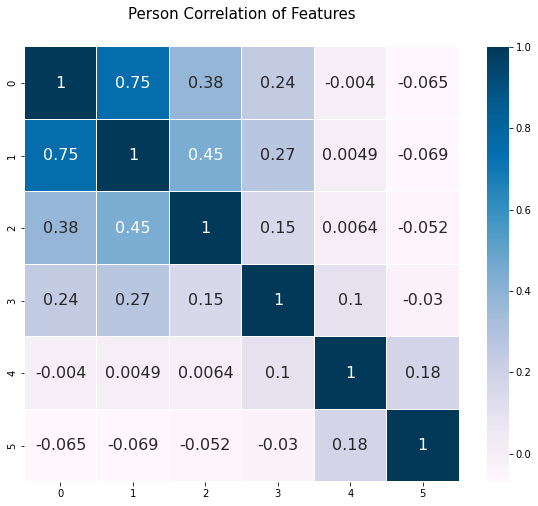

In [17]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

feature = data[['viewCount','likeCount','commentCount','subscriber','title_symbol','noun']]
scaler = StandardScaler()
feature= scaler.fit_transform(feature) 
#heatmap_data=data[['viewCount','likeCount','commentCount','subscriber','title_symbol','noun']]
heatmap_data=pd.DataFrame(feature)


colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [18]:
use_data.head()

,level_0,index,preprocessed_title,date_diff,category,views_bin,likeCount
0,0,0,전직 udt 특수부대 학원에 가다 ! 숨참기 8분 30초 ㄷㄷ ? 달려라 김계란 e...,911,스포츠_운동,700,62590.0
1,1,1,110만 유튜버 해외여행 클라스 ㄷㄷ,93,스포츠_운동,700,54094.0
2,2,2,푸쉬업 이렇게 제발 하지마세요 팔꿈치 박살,1218,스포츠_운동,700,65041.0
3,3,3,북한 잠수함에 권총 한 자루를 들고간 udt 작전 실화 with 유병호 준위,993,스포츠_운동,700,59601.0
4,4,4,udt vs 프로 파이터들 달려라 김계란 ep2 팀매드 체육관 인턴 1부,967,스포츠_운동,700,39466.0


In [19]:
use_data.drop(['level_0','index'],axis=1,inplace=True)

In [20]:
from sklearn.preprocessing import LabelEncoder

#조회수 구간 -> 범주형 변수로 만들기
le = LabelEncoder()
result = le.fit_transform(use_data['views_bin'])
use_data['views_bin'] = result

In [21]:
data.views_bin.value_counts() #범주형 변수로 변환하기 전 조회수 구간

250    11942
1      10933
30     10793
100    10608
700    10178
Name: views_bin, dtype: int64

In [22]:
use_data.views_bin.value_counts() #변환한 후 조회수 구간

3    11936
1    10769
0    10760
2    10591
4    10178
Name: views_bin, dtype: int64

In [23]:
use_data.shape

(54234, 5)

In [24]:
#카테고리 변수 -> 범주형 변수로 변환
le = LabelEncoder()
result = le.fit_transform(use_data['category'])
use_data['category'] = result

In [25]:
from scipy.stats import chi2_contingency

obs = pd.crosstab(use_data.views_bin, use_data.category)
chi2_contingency(obs,correction=False) # views_bin과 category간에는 유의한 상관성 존재

(8600.208597501172,
 0.0,
 20,
 array([[1488.19485931, 1901.85787513, 1960.78253494, 1863.76516576,
         1749.68543718, 1795.71412767],
        [1489.43963197, 1903.44864845, 1962.42259468, 1865.32407715,
         1751.14892872, 1797.21611904],
        [1464.82079507, 1871.98668732, 1929.98585758, 1834.49227422,
         1722.20431832, 1767.51006749],
        [1650.84515249, 2109.71892171, 2175.08367445, 2067.46291994,
         1940.91499797, 1991.97433344],
        [1407.69956116, 1798.98786739, 1854.72533835, 1762.95556293,
         1655.04631781, 1698.58535236]]))

In [26]:
data.category.value_counts() #범주형 변수로 변환하기 전 카테고리 변수

반려애완동물    9883
education           9586
뉴스/정치/사회            9516
주식부동산경제             9144
스포츠_운동              8819
IT_컴퓨터              7506
Name: category, dtype: int64

In [27]:
use_data.category.value_counts() #변환한 후 카테고리 변수 

2    9883
1    9586
3    9394
5    9051
4    8819
0    7501
Name: category, dtype: int64

In [28]:
#use_data.subscriber.hist() # 얘를 정규화하거나 범주형으로 만들어서 넣어줘야할듯--> 아무나 시도 ㄱㄱ

In [29]:
#use_data.subscriber.describe()

In [30]:
#import scipy.stats as stats
#stats.pearsonr(use_data.subscriber,use_data.views_bin)

In [31]:
#import math # 구간 나눠주기 -> multiclass classification

#for index, view in enumerate(use_data['subscriber']):
#  if view >=2500000:  use_data['subscriber'][index] =  250
#  elif view >=1500000:  use_data['subscriber'][index] = 150
#  elif view >= 500000 : use_data['subscriber'][index] = 50
#  elif view < 500000: use_data['subscriber'][index] = 0

In [32]:
#use_data['subscriber'].value_counts()

In [33]:
#import scipy.stats as stats
#stats.pearsonr(use_data.subscriber,use_data.views_bin)

In [34]:
use_data.columns

Index(['preprocessed_title', 'date_diff', 'category', 'views_bin',
       'likeCount'],
      dtype='object')

In [35]:
import scipy.stats as stats
stats.pearsonr(use_data.date_diff,use_data.views_bin)

(0.10749867252320996, 4.20207567676354e-139)

In [36]:
##카테고리 변수 -> 범주형 변수로 변환
#le = LabelEncoder()
#result = le.fit_transform(use_data['subscriber'])
#use_data['subscriber'] = result

In [37]:
feature = np.array(use_data['likeCount']).reshape(-1,1)
scaler = StandardScaler()
feature = scaler.fit_transform(feature) 

In [38]:
feature

array([[ 2.10944651],
       [ 1.77634945],
       [ 2.20554125],
       ...,
       [-0.3149559 ],
       [-0.31585765],
       [-0.31346606]])

In [39]:
use_data['likeCount_scaled'] = feature

In [40]:
feature = np.array(use_data['date_diff']).reshape(-1,1)
scaler = StandardScaler()
feature = scaler.fit_transform(feature)
use_data['date_diff_scaled'] = feature

In [41]:
use_data

,preprocessed_title,date_diff,category,views_bin,likeCount,likeCount_scaled,date_diff_scaled
0,전직 udt 특수부대 학원에 가다 ! 숨참기 8분 30초 ㄷㄷ ? 달려라 김계란 e...,911,4,4,62590.0,2.109447,0.559175
1,110만 유튜버 해외여행 클라스 ㄷㄷ,93,4,4,54094.0,1.776349,-0.727909
2,푸쉬업 이렇게 제발 하지마세요 팔꿈치 박살,1218,4,4,65041.0,2.205541,1.042225
3,북한 잠수함에 권총 한 자루를 들고간 udt 작전 실화 with 유병호 준위,993,4,4,59601.0,1.992259,0.688198
4,udt vs 프로 파이터들 달려라 김계란 ep2 팀매드 체육관 인턴 1부,967,4,4,39466.0,1.202839,0.647289
...,...,...,...,...,...,...,...
54292,엡손 프린터 l3156 집에 프린터는 하나는 꼭 필요하더라구요,1054,0,1,455.0,-0.326639,0.784179
54293,삼성 t7 t7 touch 이제 외장 ssd도 지문으로 잠금해제,686,0,1,750.0,-0.315074,0.205148
54294,주행요금 0원 ! 이제 약속장소까지 전기차로 갑니다 socar,535,0,1,753.0,-0.314956,-0.032443
54295,2018 new macbook pro 디자인 빼고 다 바꼈어요 ! ! 아 올해는 바...,1408,0,1,730.0,-0.315858,1.341182


In [42]:
use_data.drop(['likeCount','date_diff'],axis=1,inplace=True)

## train, val, test 데이터 분리

In [43]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(use_data, test_size = 0.1, shuffle=True, random_state=34) #일단 9:1 비율로 train, test 데이터 나눔
print(len(train_dataset))
print(len(test_dataset))

48810
5424


In [44]:
train_dataset, val_dataset  = train_test_split(train_dataset, test_size = 0.2, shuffle=True, random_state=34) #이후 train data를 8:2 비율로 train, val 데이터 추가로 나눔
print(len(train_dataset))
print(len(val_dataset))

39048
9762


In [45]:
train_dataset.preprocessed_title.loc[48042]

'또 당했습니다🤦\u200d♂️갤럭시 버즈2 포켓몬 몬스터볼 커버 사왔어요'

In [46]:
train_dataset.preprocessed_title.loc[24282]

'재 리트리버를 소녀로 착각한 행성이 🐶 리트리버를 쫒아다녀요 🐕 신나는 제주도 바닷가 산책 ｜ pom mistakes a retriever for sonyeo ! jeju'

# Tokenization

In [47]:
from transformers import BartModel
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer

tokenizer = get_kobart_tokenizer()

## 이모지 아예 제거하고
# 표정 이모지 토큰 추가
tokenizer.add_tokens(['😬', '😋', '😌', '😍', '😘', '😗', '😙', '😚', '😜', '😝', '😛', '🤑', '😎', '🤗', '😏', '😶', '😐',  '😑', '😒', '🙄', '🤔', '😳', '😟', '😠', '😡', '😔', '😕', '🙁', '☹️', '☹️',
                             '😣', '😖', '😫', '😩', '😤', '😮', '😱', '😨', '😰', '😯', '😦', '😧', '😢', '😥', '😪', '😓', '😭', '😵', '😲', '🤐', '😷', '🤒', '🤕', '😴', '💤', '💩', '😈', '👿', '👹', '👺',
                             '💀', '👻', '👽', '🤖', '😺', '😸', '😹', '😻', '😼', '😽', '🙀', '😿', '😾'])

# 신체 부위 이모지 토큰 추가
tokenizer.add_tokens(['🙌', '👏', '👋', '👍', '👊', '✊', '✌️', '👌', '✋', '💪', '🙏', '☝️', '👆', '👇', '👈', '👉', '🖕', '🤘', '🖖', '✍️', '💅', '👄', '👅', '👂', '👃', '👁', '👀', '👤', '🗣'])              

# 사람, 가족 이모지 토큰 추가 (여러 명 있는 경우 분할 될 수 있음)
tokenizer.add_tokens(['💑', '👩‍❤️‍👩', '👨‍❤️‍👨', '💏', '👩‍❤️‍💋‍👩', '👨‍❤️‍💋‍👨', '👪', '👨‍👩‍👧', '👨‍👩‍👧‍👦', '👨‍👩‍👦‍👦', '👨‍👩‍👧‍👧', '👩‍👩‍👦', '👩‍👩‍👧', '👩‍👩‍👧‍👦', '👩‍👩‍👧‍👧', '👨‍👨‍👦', '👨‍👨‍👧', '👨‍👨‍👧‍👦', '👨‍👨‍👦‍👦', '👨‍👨‍👧‍👧', '👶', '👦', '👧', '👨', '👩', '👱', '👴', '👵', 
                             '👲', '👳', '👮', '👷', '💂', '🕵', '🎅', '👼', '👸', '👰', '🚶', '🏃', '💃', '👯', '👫', '👬', '👭', '🙇', '💁', '🙅', '🙆', '🙋', '🙎', '🙍', '💇', '💆'])

# 패션, 미용 이모지 토큰 추가
tokenizer.add_tokens(['👚', '👕', '👖', '👔', '👗', '👙', '👘', '💄', '💋', '👣', '👠', '👡', '👢', '👞', '👟', '👒', '🎩', '⛑', '🎓', '👑', '🎒', '👝', '👛', '👜', '💼', '👓', '🕶', '💍', '🌂'])


# 음식 이모지 토큰 추가
tokenizer.add_tokens(['🍏', '🍎', '🍐', '🍊', '🍋', '🍌', '🍉', '🍇', '🍓', '🍈', '🍒', '🍑', '🍍', '🍅', '🍆', '🌶', '🌽', '🍠', '🍯', '🍞', '🧀', '🍗', '🍖', '🍤', '🍳', '🍔', '🍟', '🌭', '🍕', '🍝', 
                             '🌮', '🌯', '🍜', '🍲', '🍥', '🍣', '🍱', '🍛', '🍙', '🍚', '🍘', '🍢', '🍡', '🍧', '🍨', '🍦', '🍰', '🎂', '🍮', '🍬', '🍭', '🍫', '🍿', '🍩', '🍪', '🍺', '🍻', '🍷', '🍸', '🍹', '🍾',
                             '🍶', '🍵', '☕️', '🍼', '🍴', '🍽'])

# 동물, 환경 이모지 토큰 추가
tokenizer.add_tokens(['🐶', '🐱','🐭','🐹', '🐰', '🐻', '🐼', '🐨', '🐯', '🦁', '🐮', '🐷', '🐽', '🐸', '🐙', '🐵', '🙈', '🙉', '🙊', '🐒', '🐔', '🐧', '🐦', '🐤', '🐣', '🐥', '🐺', '🐗', '🐴', '🦄', '🐝', 
                             '🐛', '🐌', '🐞', '🐜', '🕷', '🦂', '🦀', '🐍', '🐢', '🐠', '🐟', '🐡', '🐬', '🐳', '🐋', '🐊', '🐆', '🐅', '🐃', '🐂', '🐄', '🐪', '🐫', '🐘', '🐐', '🐎', '🐖', '🐀', '🐁', '🐏', '🐑',
                              '🐓', '🦃', '🕊', '🐕', '🐩', '🐈', '🐇', '🐿', '🐾', '🐉','🐲', '🌵', '🎄', '🌲', '🌳', '🌴', '🌱', '🌿', '☘', '🍀', '🎍', '🎋', '🍃', '🍂', '🍁', '🌾', '🌺', '🌻', '🌹', '🌷', '🌼', '🌸',
                              '💐', '🍄', '🌰', '🎃', '🐚', '🕸', '🌎', '🌍', '🌏', '🌕', '🌖', '🌗', '🌘', '🌑', '🌒', '🌓', '🌔', '🌚', '🌝', '🌛', '🌜', '🌞', '🌙', '⭐️', '🌟', '💫', '✨', '☄', '☀️', '🌤', '⛅️',
                              '🌥', '🌦', '☁️', '🌧', '⛈', '🌩', '⚡️', '🔥', '💥', '❄️', '🌨', '🔥', '💥', '❄️', '🌨', '☃️', '⛄️', '🌬', '💨' ,'🌪', '🌫', '☂️', '☔️', '💧', '💦', '🌊'])

# 스포츠, 취미활동 이모지 토큰 추가
tokenizer.add_tokens(['⚽️', '🏀', '🏈', '⚾️', '🎾', '🏐', '🏉', '🎱', '⛳️', '🏌', '🏓', '🏸', '🏒', '🏑', '🏏', '🎿', '⛷', '🏂', '⛸', '🏹', '🎣', '🚣', '🏊', '🏄', '🛀', '⛹', '🏋', '🚴', '🚵', '🏇', '🕴', '🏆',
                             '🎽', '🏅', '🎖', '🎗', '🏵', '🎫', '🎟', '🎭', '🎨', '🎪', '🎤', '🎧', '🎼', '🎹', '🎷', '🎺', '🎸', '🎻', '🎬', '🎮', '👾', '🎯', '🎲', '🎰', '🎳'])

# 여행 이모지 토큰 추가
tokenizer.add_tokens(['🚗', '🚕', '🚙', '🚌', '🚎', '🏎', '🚓', '🚑', '🚒', '🚐', '🚚', '🚛', '🏍', '🚲', '🚨', '🚔', '🚍', '🚘', '🚖', '🚡', '🚠', '🚟', '🚃', '🚋', '🚝', '🚄', '🚅', '🚈', '🚞', '🚂', '🚆', 
                             '🚇', '🚊', '🚉', '🚁', '🛩', '✈️', '🛫', '🛬', '⛵️', '🛥', '🚤', '⛴', '🛳', '🚀', '🛰', '💺', '⚓️', '🚧', '⛽️', '🚏', '🚦', '🚥', '🏁', '🚢', '🎡', '🎢', '🎠', '🏗', '🌁', '🗼', '🏭', '⛲️',
                             '🎑', '⛰', '🏔', '🗻', '🌋', '🗾', '🏕', '⛺️', '🏞', '🛣', '🛤', '🌅', '🌄', '🏜', '🏖', '🏝', '🌇', '🌆', '🏙', '🌃', '🌉', '🌌', '🌠', '🎇', '🎆', '🌈', '🏘', '🏰', '🏯', '🏟', '🗽', '🏠',
                             '🏡', '🏚', '🏢', '🏬', '🏣', '🏤', '🏥', '🏦', '🏨', '🏪', '🏫', '🏩', '💒', '🏛', '⛪️', '🕌', '🕍', '🕋', '⛩'])

# 사물 이모지 토큰 추가
tokenizer.add_tokens(['📱', '📲', '💻', '⌨', '🖥', '🖨', '🖱', '🖲', '🕹', '🗜', '💽', '💾', '💿', '📀', '📼', '📷', '📸', '📹', '🎥', '📽', '🎞', '📞', '📟', '📠', '📺', '📻', '🎙', '🎛', '⏲', '⏰', '🕰', '⏳', '⌛️',
                             '📡', '🔋', '🔌', '💡', '🔦', '🕯', '🗑', '🛢', '💸', '💵', '💴', '💶', '💷', '💰', '💳', '💎', '⚖', '🔧', '🔨', '⚒', '🛠', '⛏', '🔩', '⚙', '⛓', '🔫', '💣', '🔪', '🗡', '⚔', '🛡', '🚬', '☠', '⚰',
                             '⚱', '🏺', '🔮', '📿', '💈', '⚗', '🔭', '🔬', '🕳', '💊', '💉', '🌡', '🏷', '🔖', '🚽', '🚿', '🛁', '🔑', '🗝', '🛋', '🛌', '🛏', '🚪', '🛎', '🖼', '🗺', '⛱', '🗿', '🛍', '🎈', '🎏', '🎀', '🎁', '🎊',
                             '🎉', '🎎', '🎐', '🎌', '🏮', '✉️', '📩', '📨', '📧', '💌', '📮', '📪', '📫', '📬', '📭', '📦', '📯', '📥', '📤', '📜', '📃', '📑', '📊', '📈', '📉', '📄', '📅', '📆', '🗓', '📇', '🗃', '🗳',
                             '🗄', '📋', '🗒', '📁', '📂', '🗂', '🗞', '📰', '📓', '📕', '📗', '📘', '📙', '📔', '📒', '📚', '📖', '🔗', '📎', '🖇', '✂️', '📐', '📏', '📌', '📍', '🚩', '🏳', '🏴', '🔐', '🔒', '🔓', '🔏', '🖊',
                             '🖊', '🖋', '✒️', '📝', '✏️', '🖍', '🖌', '🔍', '🔎'])

# 감정, 심볼 이모지 토큰 추가 
tokenizer.add_tokens(['💛', '💙', '💜', '💔', '❣️', '💞', '💓', '💗', '💖', '💘', '💝', '💟', '☮', '✝️', '☪', '🕉', '☸', '✡️', '🔯', '🕎', '☯️', '☦', '🛐', '♈️', '♉️', '♊️', '♌️', '♍️', '🆔', '⚛', '☢', '☣', '📴',
                             '📳', '✴️', '🆚', '💮', '🅰️', '🅱️', '🆎', '🆑', '🅾️', '🆘', '⛔️', '📛', '🚫', '❌', '⭕️', '💢', '🚷', '🚯', '🚳', '🚱', '🔞', '📵', '❗️', '❕', '❓', '❔', '💯', '🔅', '🔆', '🔱', '⚜', '〽️',
                             '⚠️', '🚸', '🔰', '♻️', '💹', '❇️', '✳️', '❎', '✅', '💠', '🌀', '➿', '🌐', 'Ⓜ️', '🏧', '🛂', '🛃', '🛄', '🛅', '♿️', '🚭', '🚾', '🅿️', '🚰', '🚹', '🚺', '🚼', '🚻', '🚮', '🎦', '📶', '🈁',
                             '🆖', '🆗', '🆙', '🆒', '🆕', '🆓', '🔟', '🔢', '⏸', '⏯', '⏹', '⏺', '⏭', '⏮', '⏩', '⏪', '🔀', '🔁', '🔂', '🔼', '🔽', '⏫', '⏬', '➡️', '⬅️', '⬆️', '⬇️', '🔄', '↪️', '↩️', '⤴️',
                             '⤵️', 'ℹ️', '🔤', '🔡', '🔠', '🔣', '🎵', '🎶', '〰️', '➰', '🔃', '➕', '➖', '➗', '✖️', '💲', '💱', '™️', '🔚', '🔙', '🔛', '🔝', '🔜', '☑️', '🔘', '⚪️', '⚫️', '🔴', '🔵', '🔸', '🔹', '🔶',
                             '🔷', '🔺', '▫️', '⬛️', '⬜️', '🔻', '◼️', '◻️', '◾️', '◽️', '🔲', '🔳', '🔈', '🔉', '🔊', '🔇', '📣', '📢', '🔔', '🔕', '🃏', '🀄️', '🎴', '💭', '🗯', '💬', '🕐', '🕑', '🕒', '🕓', '🕔', '🕕', '🕖',
                             '🕗', '🕘', '🕙', '🕚', '🕛', '🕜', '🕝', '🕞', '🕟', '🕠', '🕡', '🕢', '🕣', '🕤', '🕥', '🕦', '🕧'])

model = BartModel.from_pretrained(get_pytorch_kobart_model())
inputs = tokenizer([train_dataset.preprocessed_title.iloc[37]], return_tensors='pt')
#model(inputs['input_ids'])

using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_cased_ff4bda5738.zip


In [48]:
ex1 = tokenizer.encode(train_dataset.preprocessed_title.iloc[24282])
tokenizer.convert_ids_to_tokens(ex1)

['▁너',
 '네',
 '도',
 '▁이',
 '럼',
 '▁?',
 '▁',
 'ᄏ',
 'ᄏ',
 'ᄏ',
 'ᄏ',
 '▁m',
 'b',
 'ti',
 '▁유형',
 '별',
 '▁공부',
 '하는',
 '▁모습',
 '▁입시',
 '덕',
 '후']

In [49]:
# train, val에 사용
class Train_Val_Dataset(Dataset):

    def __init__(self, df,max_seq_len=64):
        self.data = df
        self.tokenizer = get_kobart_tokenizer()
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):

        record = self.data.iloc[index]
        #text, table, label = str(record["preprocessed_title"]), record[['subscriber', 'date_diff','category']],int(record["views_bin"])
        text, table, label = str(record["preprocessed_title"]), record[['category','likeCount_scaled','date_diff_scaled']],int(record["views_bin"])
        tokens = (
            [self.tokenizer.bos_token]
            + self.tokenizer.tokenize(text)
            + [self.tokenizer.eos_token]
        )
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[: self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id
            ]
            attention_mask = attention_mask[: self.max_seq_len]
        return {
            "input_text": np.array(encoder_input_id, dtype=np.int_),
            "input_table": np.array(table, dtype=np.int_),
            "attention_mask": np.array(attention_mask, dtype=float),
            "labels": np.array(label, dtype=np.int_),
        }
    def __len__(self):
        return len(self.data)
    
# test 예측에 사용
class TestDataset(Dataset):

    def __init__(self, df,max_seq_len=64):
        self.data = df
        self.tokenizer = get_kobart_tokenizer()
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):

        record = self.data.iloc[index]
        #text, table = str(record["preprocessed_title"]), record[['subscriber', 'date_diff','category']]
        text, table = str(record["preprocessed_title"]), record[['category','likeCount_scaled','date_diff_scaled']]
        tokens = (
            [self.tokenizer.bos_token]
            + self.tokenizer.tokenize(text)
            + [self.tokenizer.eos_token]
        )
        encoder_input_id = self.tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(encoder_input_id)
        if len(encoder_input_id) < self.max_seq_len:
            while len(encoder_input_id) < self.max_seq_len:
                encoder_input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            encoder_input_id = encoder_input_id[: self.max_seq_len - 1] + [
                self.tokenizer.eos_token_id
            ]
            attention_mask = attention_mask[: self.max_seq_len]
        return {
            "input_ids": np.array(encoder_input_id, dtype=np.int_),
            "input_table": np.array(table, dtype=np.int_),
            "attention_mask": np.array(attention_mask, dtype=float),
        }


    def __len__(self):
        return len(self.data)

In [50]:
TRAIN_BATCH_SIZE = 24 # batch size가 클수록 global minimum에 도달하는 속도가 증가합니다. (GPU 메모리에 따라 변경해 주세요, 너무 크면 OOM 문제가 발생합니다.)
TEST_BATCH_SIZE = 1

In [51]:
train_data = Train_Val_Dataset(train_dataset)
val_data = Train_Val_Dataset(val_dataset)
test_data = TestDataset(test_dataset)

# batch_size 만큼 데이터 분할
train_dataloader = DataLoader(train_data,
                                batch_size=TRAIN_BATCH_SIZE,
                                shuffle=True)

val_dataloader = DataLoader(val_data,
                            batch_size=TRAIN_BATCH_SIZE,
                            shuffle=False) #drop_last=True

test_dataloader = DataLoader(test_data,
                                batch_size=TEST_BATCH_SIZE,
                                shuffle=False)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
using cached model. /content/.cache/kobart_base_tokenizer_cased_cf74400bce.zip
1627
407
5424


In [52]:
train_data.__getitem__(3)

{'attention_mask': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'input_table': array([1, 0, 0]),
 'input_text': array([    0, 22444, 11300, 14489, 16609, 12024, 20386, 11921, 14461,
        15691, 14460, 14460, 11853, 11300, 16069, 13090, 16211,     1,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,
            3]),
 'labels': array(4)}

## 모델링
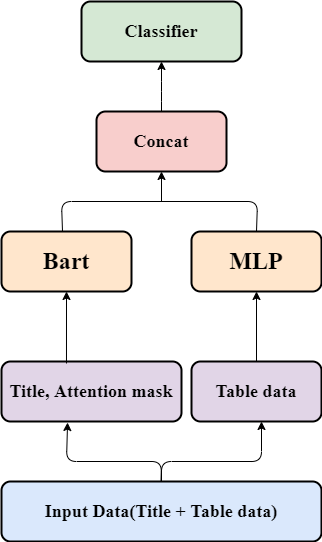

In [53]:
import torch.nn as nn
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BartForSequenceClassification

In [54]:
bart = BartModel.from_pretrained(get_pytorch_kobart_model())
bart.eval()

using cached model. /content/.cache/kobart_base_cased_ff4bda5738.zip


BartModel(
  (shared): Embedding(30000, 768, padding_idx=3)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(30000, 768, padding_idx=3)
    (embed_positions): BartLearnedPositionalEmbedding(1028, 768, padding_idx=3)
    (layers): ModuleList(
      (0): BartEncoderLayer(
        (self_attn): BartAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): BartEncoderLayer(
        (self_attn): BartAttention(
   

In [55]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
#outs = model(input_ids = batch["input_ids"], attention_mask=batch["attention_mask"],labels=batch['labels'])
outs = bart(input_ids = batch["input_text"], attention_mask=batch["attention_mask"])
print(outs.keys())

odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])


In [56]:
outs['last_hidden_state'].shape

torch.Size([24, 64, 768])

In [57]:
hidden_states = outs['last_hidden_state']
hidden_states = hidden_states.view(hidden_states.size(0),-1,hidden_states.size(-1))[ :, -1, :] #.shape # classification의 head # eos token은 없는걸로~,,
hidden_states.shape #(batch, 768)

torch.Size([24, 768])

In [58]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim): # input_dim
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Sequential(nn.Linear(input_dim, input_dim//2),
                                    nn.ReLU(),
                                    nn.Linear(input_dim//2, input_dim//4),
                                    nn.ReLU(),
                                    nn.Linear(input_dim//4, output_dim))
    def forward(self, x):
        output = self.linear(x)
        return output

In [59]:
class FinalModel(nn.Module):
    def __init__(self, table_dim, num_label):  # table_dim은 정형데이터의 column 수라 생각하면 됨
        super(FinalModel, self).__init__()
        self.text_extractor = bart 
        self.table_extractor = nn.Sequential(nn.Linear(table_dim, 768//2),
                                             nn.ReLU(),
                                             nn.Linear(768//2, 768),
                                             nn.ReLU())
        self.classifier = Classifier(768 * 2, num_label)
    
    def forward(self, x):
        text_input = x['input_text'] 
        attention_input = x['attention_mask']
        table_input = x['input_table'].float() # (batch_size, table_dim)
        text_feature = self.text_extractor(text_input, attention_input)['last_hidden_state'] # (batch_size, 768)
        text_feature =  text_feature.view(text_feature.size(0),-1,text_feature.size(-1))[ :, -1, :]
        table_feature = self.table_extractor(table_input) # (batch_size, 768)
        fusion_input = torch.cat([text_feature, table_feature], dim = 1) # (batch_size, 768 * 2)
        output = self.classifier(fusion_input)
        return output



In [60]:
model = FinalModel(table_dim=3, num_label=5) # 현재 사용하는 정형데이터 feature 수는 3개이므로 table_dim=3
#model = FinalModel(table_dim=2, num_label=5) # 현재 사용하는 정형데이터 feature 수는 2개이므로 table_dim=3

In [61]:
dataiter = iter(train_dataloader)
batch = dataiter.next()
out = model(batch)
out.shape

torch.Size([24, 5])

## 모델 훈련

In [62]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [63]:
#훈련을 위한 함수
from tqdm import tqdm
def train_function(model, optimizer, loss_func, num_epochs):
    loss_array = []
    for i in tqdm(range(num_epochs)):
        for j, batch_data in enumerate(train_dataloader):
            x = batch_data
            for key, value in x.items():
                 x[key] = x[key].to(device)
            y = batch_data['labels'].to(device)
        
            optimizer.zero_grad()
            output = model(x)
            loss = loss_func(output,y)
            loss.backward()
            optimizer.step()
            
        loss_array.append(loss.data.cpu().detach().numpy())
        print(f'epoch{i+1} training loss: {loss.data}') # 1epoch 마다 loss 출력
        test_function(model)
        
    return loss_array

In [64]:
#validation셋에 대해 정확도 출력하는 함수
def test_function(model):
    correct =0
    total = 0

    with torch.no_grad():
        for batch_data in val_dataloader:
            x = batch_data
            for key, value in x.items():
                 x[key] = x[key].to(device)
            y = batch_data['labels'].to(device)
            output=model(x)
            _, pred = torch.max(output,axis=1)#가장 큰 값과 인덱스 반환
            total += y.shape[0]
            correct += torch.sum(pred==y)
        print('Accuracy of Test Data:{}%'.format(100*(correct/total)))  

In [65]:
#loss history를 받을때, 이를 그래프로 시각화하는 함수
import matplotlib.pyplot as plt

def show_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.show()

In [66]:
NUM_EPOCHS = 5
LR = 1e-3
TABLE_DIM = 3
#TABLE_DIM = 2
NUM_LABELS = 5

In [67]:
import torch.optim as optim

model = FinalModel(table_dim=TABLE_DIM, num_label=NUM_LABELS).to(device) # 현재 사용하는 정형데이터 feature 수는 3개이므로 table_dim=3
loss_func = nn.CrossEntropyLoss() #이 안에 이미 softmax가 구현되어 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

## earlystopping 넣기

In [68]:
trai_losses = train_function(model, optimizer, loss_func, NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch1 training loss: 1.5584220886230469


 20%|██        | 1/5 [10:13<40:52, 613.23s/it]

Accuracy of Test Data:29.840198516845703%
epoch2 training loss: 1.5677781105041504


 40%|████      | 2/5 [20:28<30:42, 614.25s/it]

Accuracy of Test Data:32.56504821777344%
epoch3 training loss: 1.4996213912963867


 60%|██████    | 3/5 [30:42<20:28, 614.31s/it]

Accuracy of Test Data:32.68797302246094%
epoch4 training loss: 1.5166553258895874


 80%|████████  | 4/5 [40:57<10:14, 614.56s/it]

Accuracy of Test Data:32.401145935058594%
epoch5 training loss: 1.4007610082626343


100%|██████████| 5/5 [51:10<00:00, 614.10s/it]

Accuracy of Test Data:32.06310272216797%


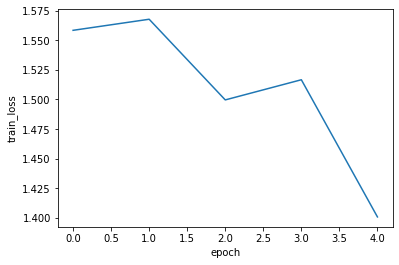

In [69]:
# epoch마다 loss 시각화
show_loss(trai_losses)

## 모델 테스트

In [71]:
# test 결과 확인
test_function(model)

Accuracy of Test Data:32.89284896850586%
